In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataset=pd.read_csv("EMG-data.csv") 
print(dataset.head())
print(dataset.shape)


   time  channel1  channel2  channel3  channel4  channel5  channel6  channel7   
0     1   0.00001  -0.00002  -0.00001  -0.00003   0.00000  -0.00001   0.00000  \
1     5   0.00001  -0.00002  -0.00001  -0.00003   0.00000  -0.00001   0.00000   
2     6  -0.00001   0.00001   0.00002   0.00000   0.00001  -0.00002  -0.00001   
3     7  -0.00001   0.00001   0.00002   0.00000   0.00001  -0.00002  -0.00001   
4     8  -0.00001   0.00001   0.00002   0.00000   0.00001  -0.00002  -0.00001   

   channel8  class  label  
0  -0.00001      0      1  
1  -0.00001      0      1  
2   0.00001      0      1  
3   0.00001      0      1  
4   0.00001      0      1  
(4237907, 11)


In [3]:
print("\nempty values:",dataset.isnull().any().sum()) 


empty values: 0


In [4]:
dataset=dataset.drop(columns=["time"])
Class = dataset["class"]
print(Class.unique())
print("Value Count :\n", dataset["class"].value_counts())

[0 1 2 3 4 5 6 7]
Value Count :
 class
0    2725157
6     253009
5     251733
4     251570
1     250055
3     249494
2     243193
7      13696
Name: count, dtype: int64


In [5]:
##drop gesture 0 because it offers no information due to its unmarked nature
index_numbers_1=dataset[dataset["class"]==0].index 
dataset.drop(index_numbers_1,inplace=True)
##drop gesture 7 because it offers no information due to it being performed 
##by just two out of 36 patients 
index_numbers_2=dataset[dataset["class"]==7].index
dataset.drop(index_numbers_2,inplace=True)

In [6]:
dataset=dataset.groupby(['label','class'])

In [7]:
##functions for extracting sEMG features
def rms(data): ##root mean square
      return  np.sqrt(np.mean(data**2,axis=0))  

def SSI(data): ##Simple Square Integral
    return np.sum(data**2,axis=0)

def abs_diffs_signal(data): ##absolute differential signal
    return np.sum(np.abs(np.diff(data,axis=0)),axis=0)

##function for returning an estimator class name 
def print_estimator_name(estimator):
    return estimator.__class__.__name__

In [8]:
##tabulating the aggregated sEMG features
dataset=dataset.agg(['min','max',rms,SSI,abs_diffs_signal,np.ptp])

In [9]:
dataset=dataset.reset_index()
dataset.head()

label class channel1                                                          
                   min      max       rms       SSI abs_diffs_signal      ptp   
0     1     1 -0.00005  0.00004  0.000017  0.000002          0.01070  0.00009  \
1     1     2 -0.00111  0.00095  0.000210  0.000301          0.16819  0.00206   
2     1     3 -0.00087  0.00112  0.000188  0.000260          0.14544  0.00199   
3     1     4 -0.00020  0.00016  0.000056  0.000022          0.03609  0.00036   
4     1     5 -0.00031  0.00061  0.000066  0.000030          0.04939  0.00092   

  channel2           ...  channel7                                       
       min      max  ...       rms       SSI abs_diffs_signal      ptp   
0 -0.00010  0.00007  ...  0.000013  0.000001          0.00870  0.00006  \
1 -0.00047  0.00041  ...  0.000216  0.000318          0.16251  0.00153   
2 -0.00113  0.00127  ...  0.000078  0.000044          0.05866  0.00063   
3 -0.00038  0.00024  ...  0.000118  0.000095          0.07517  0.00090   
4 -0.00066  0.00035  ...  0.000084  0.000049          0.06768  0.00055   

  channel8                                                         
       min      max       rms       SSI abs_diffs_signal      ptp  
0 -0.00005  0.00002  0.000014  0.000001          0.00921  0.00007  
1 -0.00070  0.00054  0.000150  0.000153          0.11696  0.00124  
2 -0.00073  0.00051  0.000161  0.000190          0.11869  0.00124  
3 -0.00032  0.00026  0.000083  0.000047          0.04984  0.00058  
4 -0.00030  0.00045  0.000060  0.000025          0.04606  0.00075  

[5 rows x 50 columns]

In [10]:
temp2=dataset

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


In [12]:
estimators=[]
accuracy=[]
f1_macro=[]

In [13]:
features=dataset.drop(columns=["label","class"])
labels=dataset["class"]

C:\Users\moham\AppData\Local\Temp\ipykernel_15892\1506687212.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  features=dataset.drop(columns=["label","class"])


In [14]:
##Training and testing set splitting
X_train, X_test,y_train,y_test= train_test_split(features,labels,test_size=0.30, random_state=1)

In [15]:
## Data normalization
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train -= mean
X_train /= std
X_test -= mean
X_test /= std

In [16]:
y_train = y_train -1
y_test = y_test  - 1

In [17]:
trainingtarget = y_train
testtarget  = y_test

from tensorflow.keras.utils import to_categorical
# Convert labels to one-hot encoded format
trainLabels  = to_categorical(trainingtarget)
testLabels   = to_categorical(testtarget)

In [18]:
# creating a function for plotting

def plot(loss,val_loss,acc,val_acc):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('acc')
    plt.legend()
    plt.show()

In [19]:
from tensorflow.keras import layers, Sequential, optimizers, Input, Model

model = Sequential([
    layers.Dense(1024, input_shape=(48,), activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),  # Adding dropout with a rate of 0.2
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),  # Adding dropout with a rate of 0.2
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(6, activation='softmax')
])


In [20]:
# saving model, creating log for tensorboaed and applying few callbacks
 # This callback saves logs for visualization in TensorBoard. 
# uses the log_dir parameter to specify the directory where the logs will be saved.
def callbacks(Log,Dir):
  import tensorflow as tf
  import os

  Filepath = Path
  logdir = os.path.join(Filepath, Dir)
  callbacks_list = [tf.keras.callbacks.TensorBoard(
                    log_dir=logdir,                 #  tensorboard log path      
                    histogram_freq=1,),
                    tf.keras.callbacks.EarlyStopping(   # stop if not improving
                    monitor='val_accuracy',patience=2,),           # monitor validation accuracy
                    tf.keras.callbacks.ModelCheckpoint(
                    filepath= Filepath,             # save model path
                    monitor='val_loss',             # only save best weights
                    save_best_only=True,)]
  return callbacks_list

In [21]:
# from tensorflow.keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(monitor="loss",patience=3)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              50176     
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [22]:
Path = "my_model_one"
Dir = "my_log_dir"   
Call_B_Fun = callbacks(Path,Dir)

batch_size = 512            
epochs = 200                
          

history = model.fit(X_train,trainLabels,
                    batch_size=batch_size,
                    epochs = epochs,
                    validation_split = 0.3,
                    callbacks=Call_B_Fun
                     )

model.summary()

Epoch 1/200
1/1 [==============================] - ETA: 0s - loss: 1.7915 - accuracy: 0.2000

INFO:tensorflow:Assets written to: my_model_one\assets


INFO:tensorflow:Assets written to: my_model_one\assets


1/1 [==============================] - 6s 6s/step - loss: 1.7915 - accuracy: 0.2000 - val_loss: 1.7456 - val_accuracy: 0.4130
Epoch 2/200
1/1 [==============================] - ETA: 0s - loss: 1.7151 - accuracy: 0.4667

INFO:tensorflow:Assets written to: my_model_one\assets


INFO:tensorflow:Assets written to: my_model_one\assets


1/1 [==============================] - 3s 3s/step - loss: 1.7151 - accuracy: 0.4667 - val_loss: 1.6952 - val_accuracy: 0.4348
Epoch 3/200
1/1 [==============================] - ETA: 0s - loss: 1.6286 - accuracy: 0.4762

INFO:tensorflow:Assets written to: my_model_one\assets


INFO:tensorflow:Assets written to: my_model_one\assets


1/1 [==============================] - 2s 2s/step - loss: 1.6286 - accuracy: 0.4762 - val_loss: 1.6346 - val_accuracy: 0.3913
Epoch 4/200
1/1 [==============================] - ETA: 0s - loss: 1.5177 - accuracy: 0.5048

INFO:tensorflow:Assets written to: my_model_one\assets


INFO:tensorflow:Assets written to: my_model_one\assets


1/1 [==============================] - 3s 3s/step - loss: 1.5177 - accuracy: 0.5048 - val_loss: 1.5635 - val_accuracy: 0.4783
Epoch 5/200
1/1 [==============================] - ETA: 0s - loss: 1.3781 - accuracy: 0.5143

INFO:tensorflow:Assets written to: my_model_one\assets


INFO:tensorflow:Assets written to: my_model_one\assets


1/1 [==============================] - 2s 2s/step - loss: 1.3781 - accuracy: 0.5143 - val_loss: 1.4752 - val_accuracy: 0.5435
Epoch 6/200
1/1 [==============================] - ETA: 0s - loss: 1.3016 - accuracy: 0.5048

INFO:tensorflow:Assets written to: my_model_one\assets


INFO:tensorflow:Assets written to: my_model_one\assets


1/1 [==============================] - 2s 2s/step - loss: 1.3016 - accuracy: 0.5048 - val_loss: 1.3991 - val_accuracy: 0.5435
Epoch 7/200
1/1 [==============================] - ETA: 0s - loss: 1.1688 - accuracy: 0.5333

INFO:tensorflow:Assets written to: my_model_one\assets


INFO:tensorflow:Assets written to: my_model_one\assets


1/1 [==============================] - 2s 2s/step - loss: 1.1688 - accuracy: 0.5333 - val_loss: 1.3186 - val_accuracy: 0.5000
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              50176     
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 64)                8256   

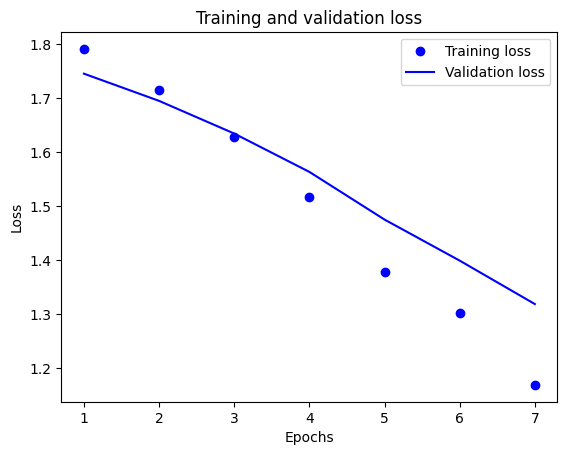

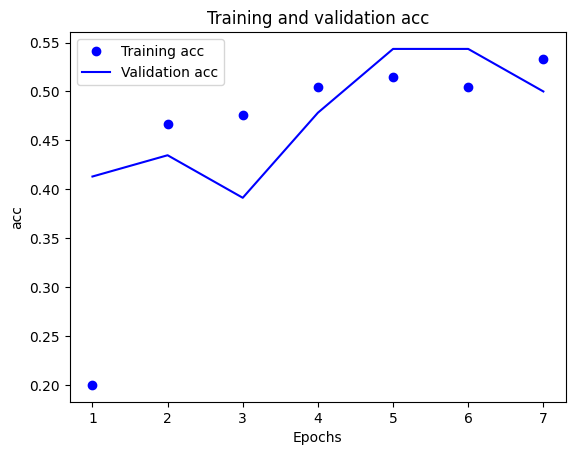

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plot(loss,val_loss,acc,val_acc)

In [24]:
# saving our model
model.save('my_model_one/emg_1.h5')

In [25]:
# loading saved model
from tensorflow.keras.models import load_model
emg = 'my_model_one/emg_1.h5'
emg_model = load_model(emg)

In [27]:
# Removing layers

new_model = Model(emg_model.inputs,emg_model.layers[-2].output) # removing layers
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_input (InputLayer)    [(None, 48)]              0         
                                                                 
 dense (Dense)               (None, 1024)              50176     
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 64)                8256

In [28]:
from tensorflow.keras import layers, Input, Model

input_tensor = Input(shape=(48,))
x = new_model(input_tensor)       # this is our old model
#z = layers.Dense(256, activation='relu')(x)
output_tensor = layers.Dense(6, activation='softmax')(x)

model = Model(input_tensor, output_tensor)

model.compile(optimizer = "adam", 
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48)]              0         
                                                                 
 model_1 (Functional)        (None, 16)                750064    
                                                                 
 dense_8 (Dense)             (None, 6)                 102       
                                                                 
Total params: 750,166
Trainable params: 750,166
Non-trainable params: 0
_________________________________________________________________


In [29]:
def callbacks(Log,Dir):
  import tensorflow as tf
  import os

  Filepath = Path
  logdir = os.path.join(Filepath, Dir)
  
  callbacks_list = [tf.keras.callbacks.TensorBoard(
                    log_dir=logdir,                 #  tensorboard log path      
                    histogram_freq=1,),
                    tf.keras.callbacks.EarlyStopping(   # stop if not improving
                    monitor='val_loss',patience=2,),           # monitor validation loss
                    tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss',factor=0.1,         # lr ko .1 se multiply kerdo (kam kerdo)
                    patience=10,),                # reduce the lrate if val loss stop improving
                    tf.keras.callbacks.ModelCheckpoint(
                    filepath= Filepath,             # save model path
                    monitor='val_loss',             # only save best weights
                    save_best_only=True,)]
  return callbacks_list

Epoch 1/200
1/1 [==============================] - ETA: 0s - loss: 2.0127 - accuracy: 0.1583

INFO:tensorflow:Assets written to: my_model_2\assets


INFO:tensorflow:Assets written to: my_model_2\assets


1/1 [==============================] - 6s 6s/step - loss: 2.0127 - accuracy: 0.1583 - val_loss: 1.7253 - val_accuracy: 0.0645 - lr: 0.0010
Epoch 2/200
1/1 [==============================] - ETA: 0s - loss: 1.5567 - accuracy: 0.3083

INFO:tensorflow:Assets written to: my_model_2\assets


INFO:tensorflow:Assets written to: my_model_2\assets


1/1 [==============================] - 3s 3s/step - loss: 1.5567 - accuracy: 0.3083 - val_loss: 1.6122 - val_accuracy: 0.2258 - lr: 0.0010
Epoch 3/200
1/1 [==============================] - ETA: 0s - loss: 1.4477 - accuracy: 0.4083

INFO:tensorflow:Assets written to: my_model_2\assets


INFO:tensorflow:Assets written to: my_model_2\assets


1/1 [==============================] - 3s 3s/step - loss: 1.4477 - accuracy: 0.4083 - val_loss: 1.5576 - val_accuracy: 0.2258 - lr: 0.0010
Epoch 4/200
1/1 [==============================] - ETA: 0s - loss: 1.3417 - accuracy: 0.4750

INFO:tensorflow:Assets written to: my_model_2\assets


INFO:tensorflow:Assets written to: my_model_2\assets


1/1 [==============================] - 3s 3s/step - loss: 1.3417 - accuracy: 0.4750 - val_loss: 1.5146 - val_accuracy: 0.2903 - lr: 0.0010
Epoch 5/200
1/1 [==============================] - ETA: 0s - loss: 1.2582 - accuracy: 0.5167

INFO:tensorflow:Assets written to: my_model_2\assets


INFO:tensorflow:Assets written to: my_model_2\assets


1/1 [==============================] - 3s 3s/step - loss: 1.2582 - accuracy: 0.5167 - val_loss: 1.4500 - val_accuracy: 0.4194 - lr: 0.0010
Epoch 6/200
1/1 [==============================] - ETA: 0s - loss: 1.1498 - accuracy: 0.5667

INFO:tensorflow:Assets written to: my_model_2\assets


INFO:tensorflow:Assets written to: my_model_2\assets


1/1 [==============================] - 3s 3s/step - loss: 1.1498 - accuracy: 0.5667 - val_loss: 1.3948 - val_accuracy: 0.5161 - lr: 0.0010
Epoch 7/200
1/1 [==============================] - ETA: 0s - loss: 1.0574 - accuracy: 0.6833

INFO:tensorflow:Assets written to: my_model_2\assets


INFO:tensorflow:Assets written to: my_model_2\assets


1/1 [==============================] - 3s 3s/step - loss: 1.0574 - accuracy: 0.6833 - val_loss: 1.3283 - val_accuracy: 0.6129 - lr: 0.0010
Epoch 8/200
1/1 [==============================] - ETA: 0s - loss: 0.9442 - accuracy: 0.6917

INFO:tensorflow:Assets written to: my_model_2\assets


INFO:tensorflow:Assets written to: my_model_2\assets


1/1 [==============================] - 3s 3s/step - loss: 0.9442 - accuracy: 0.6917 - val_loss: 1.2840 - val_accuracy: 0.5806 - lr: 0.0010
Epoch 9/200
1/1 [==============================] - ETA: 0s - loss: 0.8864 - accuracy: 0.7500

INFO:tensorflow:Assets written to: my_model_2\assets


INFO:tensorflow:Assets written to: my_model_2\assets


1/1 [==============================] - 3s 3s/step - loss: 0.8864 - accuracy: 0.7500 - val_loss: 1.2242 - val_accuracy: 0.6774 - lr: 0.0010
Epoch 10/200
1/1 [==============================] - ETA: 0s - loss: 0.8270 - accuracy: 0.7083

INFO:tensorflow:Assets written to: my_model_2\assets


INFO:tensorflow:Assets written to: my_model_2\assets


1/1 [==============================] - 4s 4s/step - loss: 0.8270 - accuracy: 0.7083 - val_loss: 1.1895 - val_accuracy: 0.7097 - lr: 0.0010
Epoch 11/200
1/1 [==============================] - ETA: 0s - loss: 0.7441 - accuracy: 0.7750

INFO:tensorflow:Assets written to: my_model_2\assets


INFO:tensorflow:Assets written to: my_model_2\assets


1/1 [==============================] - 3s 3s/step - loss: 0.7441 - accuracy: 0.7750 - val_loss: 1.1838 - val_accuracy: 0.7097 - lr: 0.0010
Epoch 12/200
1/1 [==============================] - 0s 351ms/step - loss: 0.7369 - accuracy: 0.7583 - val_loss: 1.1995 - val_accuracy: 0.7419 - lr: 0.0010
Epoch 13/200
1/1 [==============================] - 0s 333ms/step - loss: 0.6409 - accuracy: 0.7750 - val_loss: 1.2567 - val_accuracy: 0.6774 - lr: 0.0010


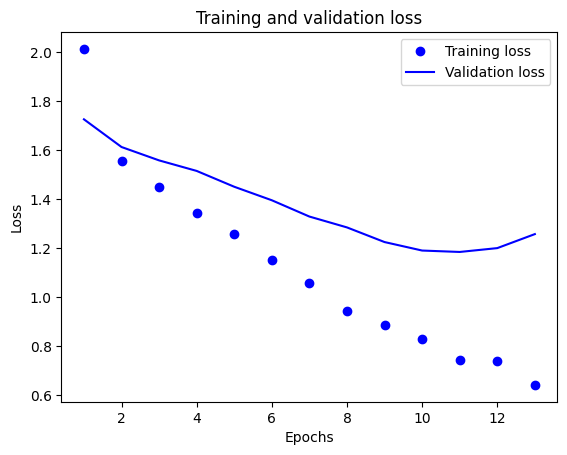

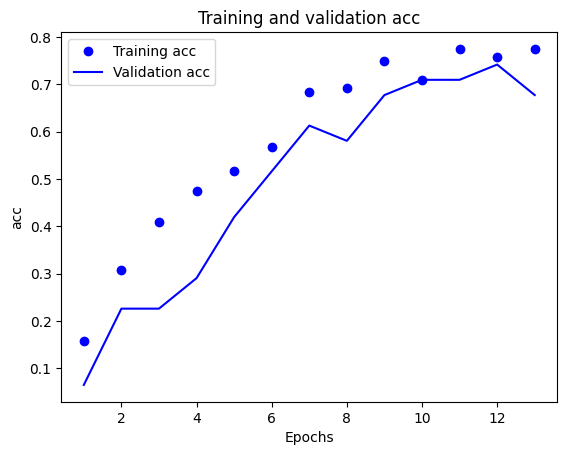

In [30]:
Path = "my_model_2"
Dir = "my_log_dir"   
Call_B_Fun = callbacks(Path,Dir)

batch_size = 512            
epochs = 200                

history = model.fit(X_train, trainLabels,
                    batch_size=batch_size, epochs = epochs,
                    validation_split = 0.2, callbacks=Call_B_Fun)

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plot(loss,val_loss,acc,val_acc)

In [31]:
# saving our model
model.save('my_model_2/emg_2.h5')

In [32]:
# loading saved model
from tensorflow.keras.models import load_model
emg = 'my_model_2/emg_2.h5'
emg_model = load_model(emg)
#emg_model.summary()

In [33]:
from tensorflow.keras import layers, Sequential

model = Sequential([
    layers.Dense(1024, input_shape=(48,), activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),  # Adding dropout with a rate of 0.2
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),  # Adding dropout with a rate of 0.2
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(6, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

model.set_weights(emg_model.get_weights())   # using pretrained model weights

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 1024)              50176     
                                                                 
 dense_10 (Dense)            (None, 512)               524800    
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)               

In [34]:
callbacks_list = [tf.keras.callbacks.EarlyStopping(   # stop if not improving
                monitor='acc',patience=5,),           # monitor validation accuracy
                tf.keras.callbacks.ModelCheckpoint(
                filepath='my_transfer_model.h5',
                monitor='val_loss',                   # only save best weights
                save_best_only=True,)]                # when vall loss is improved

batch_size = 512           
epochs = 15                

history = model.fit(X_train, trainLabels,
                    batch_size=batch_size, epochs = epochs,
                    validation_split = 0.2,
                    callbacks=callbacks_list)

Epoch 1/15
1/1 [==============================] - ETA: 0s - loss: 0.5610 - accuracy: 0.8167WARNING:tensorflow:Early stopping conditioned on metric `acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


1/1 [==============================] - 3s 3s/step - loss: 0.5610 - accuracy: 0.8167 - val_loss: 0.9456 - val_accuracy: 0.7742
Epoch 2/15
1/1 [==============================] - ETA: 0s - loss: 0.7421 - accuracy: 0.7750WARNING:tensorflow:Early stopping conditioned on metric `acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


1/1 [==============================] - 0s 73ms/step - loss: 0.7421 - accuracy: 0.7750 - val_loss: 1.0626 - val_accuracy: 0.7742
Epoch 3/15
1/1 [==============================] - ETA: 0s - loss: 0.5330 - accuracy: 0.8500WARNING:tensorflow:Early stopping conditioned on metric `acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


1/1 [==============================] - 0s 70ms/step - loss: 0.5330 - accuracy: 0.8500 - val_loss: 1.0676 - val_accuracy: 0.7419
Epoch 4/15
1/1 [==============================] - ETA: 0s - loss: 0.3816 - accuracy: 0.9250WARNING:tensorflow:Early stopping conditioned on metric `acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


1/1 [==============================] - 0s 70ms/step - loss: 0.3816 - accuracy: 0.9250 - val_loss: 1.1352 - val_accuracy: 0.7097
Epoch 5/15
1/1 [==============================] - ETA: 0s - loss: 0.4186 - accuracy: 0.8917WARNING:tensorflow:Early stopping conditioned on metric `acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


1/1 [==============================] - 0s 71ms/step - loss: 0.4186 - accuracy: 0.8917 - val_loss: 1.1639 - val_accuracy: 0.7742
Epoch 6/15
1/1 [==============================] - ETA: 0s - loss: 0.3455 - accuracy: 0.9083WARNING:tensorflow:Early stopping conditioned on metric `acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


1/1 [==============================] - 0s 75ms/step - loss: 0.3455 - accuracy: 0.9083 - val_loss: 1.1649 - val_accuracy: 0.7742
Epoch 7/15
1/1 [==============================] - ETA: 0s - loss: 0.3256 - accuracy: 0.9167WARNING:tensorflow:Early stopping conditioned on metric `acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


1/1 [==============================] - 0s 72ms/step - loss: 0.3256 - accuracy: 0.9167 - val_loss: 1.1761 - val_accuracy: 0.8065
Epoch 8/15
1/1 [==============================] - ETA: 0s - loss: 0.2369 - accuracy: 0.9500WARNING:tensorflow:Early stopping conditioned on metric `acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


1/1 [==============================] - 0s 74ms/step - loss: 0.2369 - accuracy: 0.9500 - val_loss: 1.1860 - val_accuracy: 0.8065
Epoch 9/15
1/1 [==============================] - ETA: 0s - loss: 0.2185 - accuracy: 0.9667WARNING:tensorflow:Early stopping conditioned on metric `acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


1/1 [==============================] - 0s 71ms/step - loss: 0.2185 - accuracy: 0.9667 - val_loss: 1.2326 - val_accuracy: 0.8387
Epoch 10/15
1/1 [==============================] - ETA: 0s - loss: 0.2251 - accuracy: 0.9417WARNING:tensorflow:Early stopping conditioned on metric `acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


1/1 [==============================] - 0s 76ms/step - loss: 0.2251 - accuracy: 0.9417 - val_loss: 1.2972 - val_accuracy: 0.8387
Epoch 11/15
1/1 [==============================] - ETA: 0s - loss: 0.2188 - accuracy: 0.9417WARNING:tensorflow:Early stopping conditioned on metric `acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


1/1 [==============================] - 0s 75ms/step - loss: 0.2188 - accuracy: 0.9417 - val_loss: 1.3456 - val_accuracy: 0.8387
Epoch 12/15
1/1 [==============================] - ETA: 0s - loss: 0.1845 - accuracy: 0.9583WARNING:tensorflow:Early stopping conditioned on metric `acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


1/1 [==============================] - 0s 80ms/step - loss: 0.1845 - accuracy: 0.9583 - val_loss: 1.3657 - val_accuracy: 0.8387
Epoch 13/15
1/1 [==============================] - ETA: 0s - loss: 0.1489 - accuracy: 0.9667WARNING:tensorflow:Early stopping conditioned on metric `acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


1/1 [==============================] - 0s 102ms/step - loss: 0.1489 - accuracy: 0.9667 - val_loss: 1.3361 - val_accuracy: 0.8387
Epoch 14/15
1/1 [==============================] - ETA: 0s - loss: 0.1363 - accuracy: 0.9750WARNING:tensorflow:Early stopping conditioned on metric `acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


1/1 [==============================] - 0s 74ms/step - loss: 0.1363 - accuracy: 0.9750 - val_loss: 1.3122 - val_accuracy: 0.8387
Epoch 15/15
1/1 [==============================] - ETA: 0s - loss: 0.1115 - accuracy: 0.9583WARNING:tensorflow:Early stopping conditioned on metric `acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


1/1 [==============================] - 0s 71ms/step - loss: 0.1115 - accuracy: 0.9583 - val_loss: 1.3120 - val_accuracy: 0.8387


In [35]:
model.save('my_emg_3.h5')

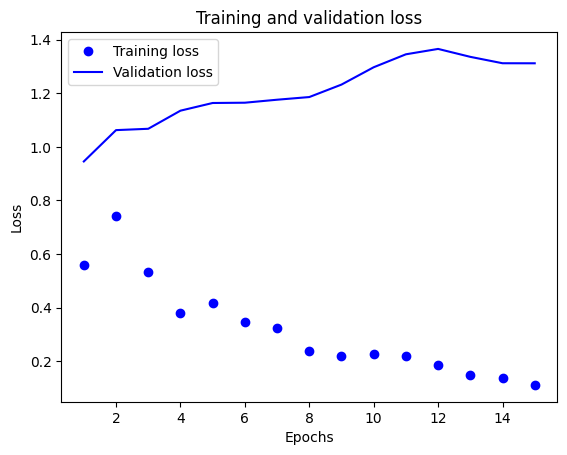

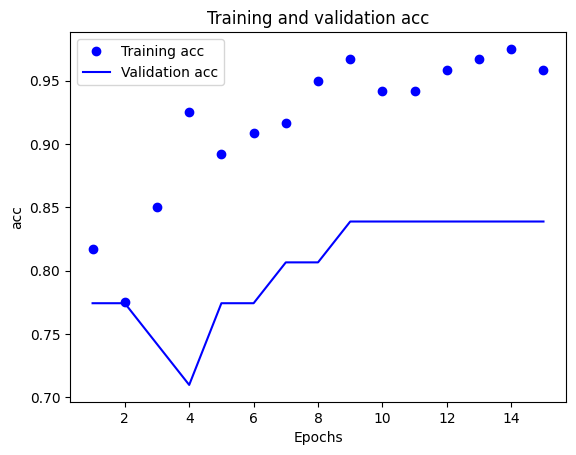

In [36]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plot(loss,val_loss,acc,val_acc)

In [37]:
evaluation = model.evaluate(X_test,  testLabels,batch_size=batch_size, verbose=2)
print()
print("Test loss :",evaluation[0]*100,"%")
print("Test accuracy :",evaluation[1]*100,"%")

1/1 - 0s - loss: 1.3518 - accuracy: 0.7846 - 36ms/epoch - 36ms/step

Test loss : 135.1818323135376 %
Test accuracy : 78.46153974533081 %


In [38]:
y_pred=model.predict(X_test)
print(y_pred)
# print(y_test)

3/3 [==============================] - 0s 4ms/step
[[9.78859782e-01 2.11210512e-02 1.74268507e-07 6.04123951e-09
  7.87972476e-06 1.11481759e-05]
 [1.72284327e-03 1.43478774e-02 3.86482524e-03 9.74914849e-01
  3.33720027e-03 1.81236456e-03]
 [4.31194756e-04 7.38159724e-06 3.82692902e-03 9.19451049e-05
  9.95542228e-01 1.00298384e-04]
 [2.57588204e-06 6.49554977e-07 2.39559988e-04 1.14460454e-05
  3.63480201e-09 9.99745786e-01]
 [3.98211271e-01 5.96695483e-01 2.69749551e-04 1.16846629e-03
  2.60080863e-03 1.05425506e-03]
 [8.01209435e-02 8.74148309e-02 4.85195825e-03 1.67849232e-02
  2.73341639e-03 8.08093905e-01]
 [3.60258127e-05 3.11198448e-07 1.01865956e-03 2.10498147e-05
  9.98907447e-01 1.65068959e-05]
 [1.71770761e-03 9.98282313e-01 3.68899112e-14 3.46383189e-08
  9.27675506e-11 6.38606612e-10]
 [9.87076223e-01 1.29114809e-02 1.53933442e-07 1.78704573e-09
  4.17977253e-06 8.00472753e-06]
 [1.31480710e-03 1.41889512e-04 8.28164071e-03 8.63664504e-03
  9.81279731e-01 3.45340930e-04]

In [40]:
# Prediction & confusion matrix - test data
y_prob = model.predict(X_test)
y_pred = np.argmax(y_prob, axis=1)
print(y_pred)

3/3 [==============================] - 0s 3ms/step
[0 3 4 5 1 5 4 1 0 4 4 1 0 0 3 1 4 5 5 3 4 3 5 5 5 0 5 3 2 3 1 0 2 2 5 5 0
 3 1 3 0 4 0 3 3 5 3 5 2 1 2 4 5 0 5 0 3 0 0 3 5 4 4 5 1]


In [41]:
# save the f1_score that used y_test and y_pred in y
y=f1_score(testtarget,y_pred,average='macro') 
# calculate the accuracy and store it in a
a=accuracy_score(testtarget,y_pred)

print(y)
print(a)

0.7534313932777201
0.7846153846153846


In [42]:
testtarget.unique()

array([0, 3, 4, 2, 1, 5], dtype=int64)

In [44]:
table1 = confusion_matrix(testtarget,y_pred)
print(table1)

[[11  0  0  0  0  0]
 [ 0  7  0  0  1  0]
 [ 1  1  2  0  0  4]
 [ 0  0  0 11  0  1]
 [ 1  0  1  2  9  0]
 [ 0  0  2  0  0 11]]


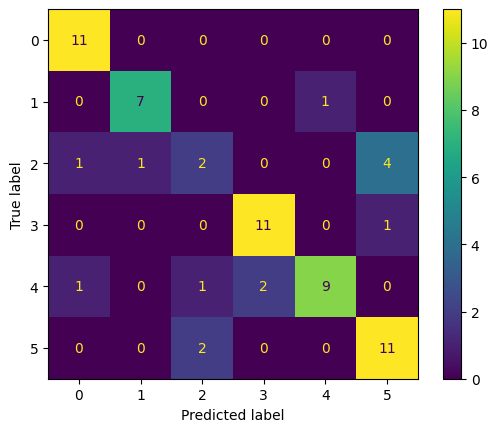

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=table1)
disp.plot()
plt.show()